In [178]:
import pandas
import numpy as np
import collections
import heapq
import itertools
import IPython.display
import re
# for these -- pip install biopython
import Bio.Seq
import Bio.SeqIO
import Bio.Align

# 1. Sequence alignment

The data comes from GISAID. It comes in the form of sequences, many of them around 29,900 characters long, some of them just a few hundred. The first step is to align the sequences, so as to be able to track mutations. I'll use an off-the-shelf package (biopython) for sequence alignment. This is very slow... at the end of this section I write out a much shorter csv file that only lists the differences from a reference sequence (provided by NIH).

If you don't have hours to spend, skip to the next section, and read in the mutations file directly (available on Moodle).

In [ ]:
# Read the full database of sequences from GISAID
# https://www.gisaid.org/
# (needs a login, which was easy to get with a university email address)

with open('data/gisaid_cov2020_sequences.fasta') as f:
    lines = [line.rstrip() for line in f.readlines()]

groups = []
for line in lines:
    if line[0] == '>':
        groups.append([line])
    else:
        groups[-1].append(line)

def clean_seq(s):
    # 'X' is interpreted as UNKNOWN, by the alignment algorithm
    # http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc89
    return re.sub('[nx-]', 'X', s.lower())
        
gisaid = pandas.DataFrame({
    'id': [group[0][1:] for group in groups],
    'seq': [Bio.Seq.Seq(clean_seq(''.join(group[1:]))) for group in groups]
})

In [ ]:
# Read the reference sequence
# https://www.ncbi.nlm.nih.gov/genbank/sars-cov-2-seqs/#reference-genome

for seq_record in Bio.SeqIO.parse("../data/NC_045512_ref.fasta", "fasta"):
    ncbi = Bio.Seq.Seq(str(seq_record.seq)).lower()

In [ ]:
# Sequences have a range of lengths, 29903 the most common, but plenty of others.
# We need to align them.
gisaid.seq.str.len().value_counts()[:20]

In [ ]:
aligner = Bio.Align.PairwiseAligner()
aligner.extend_gap_score = 0
aligner.open_gap_score = -10
aligner.mode = 'local'

In [ ]:
# For each seq, find where it differs from the reference seq.
# Comparison is O(n^2) where n is sequence length, and this is too slow for n>5000,
# so I'll do a hacky comparison in chunks of n=1000.

def mutations(ref, seq, CHUNK=1000):
    diffs = []
    for i in range(0, len(seq), CHUNK):
        alignments = aligner.align(ncbi, seq[i:i+CHUNK])
        if len(alignments) == 0: 
            continue
        alignment = alignments[0]
        if alignment.score < len(alignment.query):
            target_slices, query_slices = alignment.aligned
            for (ts0,ts1), (qs0,qs1) in zip(target_slices, query_slices):
                t = alignment.target[ts0:ts1]
                q = alignment.query[qs0:qs1]
                diffs.extend([(ts0+i, q[i]) for i in range(qs1-qs0) if t[i] != q[i] and q[i]!='X'])
    return diffs

In [ ]:
res = []

In [ ]:
for i in range(len(res), len(gisaid)):
    print(f"{i}/{len(gisaid)}: {gisaid.id[i]}")
    IPython.display.clear_output(wait=True)
    res.append(mutations(ncbi, gisaid.seq[i]))

In [ ]:
mutations = []
for _id,seq,m in zip(gisaid.id, gisaid.seq, res):
    seq = re.sub('X','',str(seq))
    if len(m) == 0:
        mutations.append( (_id,len(seq),0,pandas.NA,pandas.NA) )
    elif len(m) > 500:
        mutations.append( (_id,len(seq),len(m),pandas.NA,pandas.NA) )
    else:
        mutations.extend([(_id,len(seq),len(m),l,v) for l,v in m])
mutations = pandas.DataFrame(mutations, columns=['id','length','ndiff','loc','value'])

mutations.to_csv('data/mutations.csv', index=False)

# 2. Building the tree

## 2.1 Load the sequence data

In [2]:
mutations = pandas.read_csv('data/mutations.csv')

In [3]:
df = mutations.loc[~pandas.isna(mutations['loc'])].copy()
df['loc'] = df['loc'].astype(int)
df.sort_values(['id', 'loc'])
gisaid = df.groupby('id').apply(lambda df: list(zip(df['loc'], df['value']))) \
    .reset_index(name='mutations')
gisaid['date'] = gisaid.id.apply(lambda s: s.split('|')[-1])

d0 = pandas.to_datetime('2020-01-01', format='%Y-%m-%d')
d = pandas.to_datetime(gisaid.date, format='%Y-%m-%d')
gisaid['t'] = (d - d0).dt.days

NUM_SITES = len(df['loc'].unique())

## 2.2 Working with sequences

Sequences are represented as a list `[(loc,mutation),...]` giving the differences from a reference sequence. The functions defined below are for counting the number of differences in sequences, and for creating a new sequence by merging two or three existing sequences.

In [4]:
def zipped_mutation_list(*seqs):
    d0 = [None for _ in range(len(seqs))]
    seqs = [[(loc,val,i) for (loc,val) in s] for i,s in enumerate(seqs)]
    all_mutations = sorted(itertools.chain.from_iterable(seqs))
    sites = itertools.groupby(all_mutations, lambda x: x[0])
    def deltas(ms):
        d = d0.copy()
        for _,val,s in ms:
            d[s] = val
        return d
    res = ((loc, deltas(ms)) for loc,ms in sites)
    return res

def count_differences(Useq, Vseq, Wseq=None):
    if Wseq is None:
        # When comparing two sequences, there are only two possibilities: same ('aa') or different ('ab')
        d = 0
        for _,(ui,vi) in zipped_mutation_list(Useq,Vseq):
            if ui != vi:
                d = d+1
        return {'aa': NUM_SITES - d, 'ab': d}
    else:
        # When comparing three sequences, there are five possible configurations...
        d = {'aab': 0, 'aba': 0, 'abb': 0, 'abc': 0}
        for _,(ui,vi,wi) in zipped_mutation_list(Useq, Vseq, Wseq):
            if ui!=vi and vi!=wi:
                d['abc'] += 1
            elif ui==vi and vi!=wi:
                d['aab'] += 1
            elif ui!=vi and ui==wi:
                d['aba'] += 1
            elif ui!=vi and vi==wi:
                d['abb'] += 1
            else:
                pass
        d['aaa'] = NUM_SITES - sum(d.values())
        return d
    
def merge(Useq, Vseq, Wseq=None, *, counts):
    # Create a new sequence made by merging the given sequences.
    # counts specifies how many times to draw from each of the three sequences.
    res = []
    if Wseq is None:
        c_ab = iter(np.random.permutation([0]*counts['ab']['a'] + [1]*counts['ab']['b']))
        for loc,(vi,wi) in zipped_mutation_list(Useq,Vseq):
            if vi == wi:
                c = vi
            else:
                c = (vi,wi)[next(c_ab)]
            if c is not None:
                res.append((loc, c))
    else:
        c_abc = iter(np.random.permutation([0]*counts['abc']['a'] + [1]*counts['abc']['b'] + [2]*counts['abc']['c']))
        c_aab = iter(np.random.permutation([0]*counts['aab']['a'] + [1]*counts['aab']['b']))
        c_aba = iter(np.random.permutation([0]*counts['aba']['a'] + [1]*counts['aba']['b']))
        c_abb = iter(np.random.permutation([0]*counts['abb']['a'] + [1]*counts['abb']['b']))
        for loc,(ui,vi,wi) in zipped_mutation_list(Useq, Vseq, Wseq):
            if ui==vi and vi==wi:
                c = ui
            elif ui!=vi and vi!=wi:
                c = (ui,vi,wi)[next(c_abc)]
            elif ui==vi and vi!=wi:
                c = (ui,wi)[next(c_aab)]
            elif ui!=vi and ui==wi:
                c = (ui,vi)[next(c_aba)]
            elif ui!=vi and vi==wi:
                c = (ui,vi)[next(c_abb)]
            if c is not None:
                res.append((loc,c))
    return res

## 2.3 Representing gene sequences in a phylogenetic tree

In [5]:
# A gene-sample has a sequence, and a timestamp.
# In a phylogenetic tree, we'll also give each sample a unique id, and a pointer to its parent.

Node = collections.namedtuple('Node', ['id','parent','seq','t','is_virtual'])

def Sample(_id, seq, t):
    return Node(_id, parent=None, seq=seq, t=t, is_virtual=False)

def InferredSample(seq, t, *, counter=[0]):
    # Create a "virtual" gene-sample, and give it a unique id
    counter[0] = counter[0]+1
    return Node(f"@{counter[0]}", parent=None, seq=seq, t=t, is_virtual=True)

## 2.4 Probability model

We want to find the most likely phylogenetic tree for a set of sequences.

We'll use the following probability model:
* Each edge $U\to V$ in the tree represents a set of mutations, happening over time $\delta=V\texttt{.t}-U\texttt{.t}$, and 
transforming a sequence $U.\texttt{seq}$ to another sequence $V.\texttt{seq}$
* All edges are independent, hence the log-likelihood of a tree is the sum of the log-likelihood of each of its edges
* In each site (position) in the sequence, mutations happen at rate $\lambda$, thus the chance of zero mutations over an interval of length $\delta$ at a given site is $e^{-\lambda\delta}$
* Mutations are equally likely to be to any one of $K=4$ different symbols (G, T, C, A)

Thus, the log likelihood of an edge $U\to V$ is
$$
n_{\text{same}} \log\Bigl( e^{-\lambda\delta} + \frac{1-e^{-\lambda\delta}}{K}\Bigr) +
n_{\text{diff}} \log\Bigl(\frac{1-e^{-\lambda\delta}}{K}\Bigr)
$$
where $n_{\text{diff}}$ is the number of sites where $U.\texttt{seq}$ and $V.\texttt{seq}$ differ, $n_{\text{same}}$ is the number of sites where they are the same,
and $\delta=V\texttt{.t}-U\texttt{.t}$.

The mutation rate I'm using, $\lambda=4.4$ mutations/day, comes from a preliminary datafit. I first ran the tree-finding algorithm with $\lambda=0.5$, then I estimated $\lambda$ from the tree, and it came out to be $4.4$.

In [6]:
def loglik_edge(dt, nsame, ndiff, K=4, λ=4.4):
    res = nsame * np.log(np.exp(-λ*dt) + (1-np.exp(-λ*dt))/K) + ndiff * np.log((1-np.exp(-λ*dt))/K)
    return res

In [7]:
# What's the log likelihood of an edge U -> V?

def weight2(U,V):
    Δ = count_differences(U.seq, V.seq)
    return loglik_edge(V.t - U.t, nsame=Δ['aa'], ndiff=Δ['ab'])


# What's the maximum log likelihood of a triple u -> (v and w)?
# Let there be an intermediate virtual node <n>. The cost is just the sum of the three edges, u-n, n-v, n-w.
# We'll optimize over the timestamp of n, and its contents.

def weight3(U,V,W):
    maxweight,opt = -np.inf,None
    # Enumerate over all the possibilities for the sequence for the middle node n,
    # and also over a range of possibilities for its timestamp
    nt = np.linspace(U.t, min(V.t, W.t), 20)[1:-1]
    Δ = count_differences(U.seq, V.seq, W.seq)
    for p in range(0, Δ['abc']+1):                 # num.sites where u=n,   among abc cases
        for q in range(0, Δ['abc']+1-p):           # num.sites where n=v,   among abc cases
            r = Δ['abc'] - (p+q)                   # num.sites where n=w,   among abc cases
            for s in range(0, Δ['aab']+1):         # num.sites where n=u=v, among aab cases
                t = Δ['aab'] - s                   # num.sites where n=w,   among aab cases
                for u in range(0, Δ['aba']+1):     # num.sites where n=u=w, among aba cases
                    v = Δ['aba'] - u               # num.sites where n=v,   among aba cases
                    for w in range(0, Δ['abb']+1): # num.sites where n=u,   among abb cases
                        x = Δ['abb'] - w           # num.sites where n=v=w, among abb cases
                        N = sum(Δ.values())        # total number of sites
                        dun = q + r + t + v + x    # num.sites where u!=n
                        dnv = p + r + t + u + w    # num.sites where n!=v
                        dnw = p + q + s + v + w    # num.sites where n!=w
                        weights = (loglik_edge(nt-U.t, nsame=N-dun, ndiff=dun) + 
                                   loglik_edge(V.t-nt, nsame=N-dnv, ndiff=dnv) + 
                                   loglik_edge(W.t-nt, nsame=N-dnw, ndiff=dnw))
                        if max(weights) > maxweight:
                            maxweight = max(weights)
                            opt = (nt[np.argmax(weights)], p,q,r,s,t,u,v,w,x)
    # Create a new node at the optimal timepoint,
    # and give it a random sequence consistent with the difference-counts
    ntopt,p,q,r,s,t,u,v,w,x = opt
    c = {'abc': {'a':p, 'b':q, 'c':r}, 'aab':{'a':s, 'b':t}, 'aba':{'a':u, 'b':v}, 'abb':{'a':w, 'b':x}}
    nseq = merge(U.seq, V.seq, W.seq, counts=c)
    n = InferredSample(seq=nseq, t=ntopt)
    return (maxweight, n)


# What's the maximum log probability of <n> -> (v,w)?
# Let there be an initial virtual node n. The cost is just the sum of the two edges, n-v, n-w.
# We'll optimize over the timestamp of n, and its contents.

def weight0(V,W):
    maxweight,opt = -np.inf,None
    # Enumerate over all possible sequences for the initial node n,
    # and also over a range of possibilities for its timestamp
    nt = np.linspace(min(V.t,W.t)-5, min(V.t,W.t), 10)[:-1]
    Δ = count_differences(V.seq, W.seq)
    # Count over all possibilities for z
    for p in range(0, Δ['ab']+1):   # num.sites where n=v, among ab cases
        q = Δ['ab'] - p             # num.sites where n=w, among ab cases
        N = sum(Δ.values())
        dnv = q
        dnw = p
        weights = loglik_edge(V.t-nt, nsame=N-dnv, ndiff=dnv) + loglik_edge(W.t-nt, nsame=N-dnw, ndiff=dnw)
        if max(weights) > maxweight:
            maxweight = max(weights)
            opt = (nt[np.argmax(weights)], p,q)
    # Create a new node at the optimal timepoint,
    # and give it a random sequence consistent with the difference-counts
    ntopt,p,q = opt
    c = {'ab': {'a':p, 'b':q}}
    nseq = merge(V.seq, W.seq, counts=c)
    n = InferredSample(seq=nseq, t=ntopt)
    return (maxweight, n)

## 2.5 Constructing a phylogenetic tree

A phylogenetic tree represents the branching process by which a virus mutates and spreads.
We seek the most likely tree, i.e. the one whose weight is largest, where the weight is the sum of all of its edge weights.

In [8]:
def weight(tree):
    w = 0
    for V in tree.values():
        # At the root node, its parent pointer points to itself. Exclude it from the count.
        if V.parent != V.id:
            w += weight2(tree[V.parent], V)
    return w

#### Prim-style greedy growth

As with Prim's algorithm, we can greedily build up a tree, growing it from a start node.
Like Prim, we can add a new vertex to an existing node;
unlike Prim we'll also allow adding to an existing edge (by creating a virtual node on that edge).

In [9]:
def build_tree(samples):
    sample = {s.id: s for s in samples}
    toexplore = []

    # Keep a priority queue of nodes waiting to be added.
    # Each item in the queue will be (-weight, w_id, v_id, u_id).
    # If u_id is None:
    #     the weight is for adding W with an edge V -> W
    # elif u_id = v_id:
    #     the weight is for adding W alongside the root node, N -> (S, W)
    # else:
    #     the weight is for adding W via an intermediate, U -> N -> (V, W)
    #
    # Because edges can be modified while the tree is growing, we may have
    # an item in the priority queue that refers to an edge that doesn't exist
    # anymore. Therefore we'll implement a careless priority queue,
    # allowed to push multiple copies of W, with no decreasekey,
    # and when we pop we'll check if W has already been added.

    # Initialize the tree with the first node
    S = samples[0]
    tree = {S.id: S._replace(parent=S.id)}
    for W in samples[1:]:
        if W.t > S.t:
            heapq.heappush(toexplore, (-weight2(S,W), W.id, S.id, None))
        heapq.heappush(toexplore, (-weight0(S,W)[0], W.id, S.id, S.id))

    # Get the next-closest node, and add it to the tree according to the attachment point
    while toexplore:
        _,wid,vid,uid = heapq.heappop(toexplore)

        # If we've already added W, or if this proposal refers to an edge that has gone, skip.
        if wid in tree:
            continue
        if uid is not None and tree[vid].parent != uid:
            continue

        # Add W, via V -> W
        if uid is None:
            V,W = tree[vid], sample[wid]
            tree[W.id] = W._replace(parent=V.id)
            newnodes = [W.id]
            newedges = [(V.id, W.id)]

        # Or add W, via <n> -> (V ,W)
        elif uid == vid:
            V,W = tree[vid], sample[wid]
            _,N = weight0(V,W)
            tree[N.id] = N._replace(parent=N.id)
            tree[V.id] = V._replace(parent=N.id)
            tree[W.id] = W._replace(parent=N.id)
            newnodes = [N.id, W.id]
            newedges = [(N.id, V.id), (N.id, W.id), (N.id, N.id)]

        # Or add W, via U -> <n> -> (V, W)
        else:
            U,V,W = tree[uid], tree[vid], sample[wid]
            _,N = weight3(U,V,W)
            tree[N.id] = N._replace(parent=U.id)
            tree[V.id] = V._replace(parent=N.id)
            tree[W.id] = W._replace(parent=N.id)
            newnodes = [N.id, W.id]
            newedges = [(U.id, N.id), (N.id, V.id), (N.id, W.id)]

        # Consider all the neighbours that might be added,
        # either to a node that we just added,
        # or to an edge that we just added.

        for W in sample.values():
            if W.id in tree: continue
            for vid in newnodes:
                V = tree[vid]
                if W.t > V.t:
                    heapq.heappush(toexplore, (-weight2(V,W), W.id, V.id, None))
            for uid,vid in newedges:
                U,V = tree[uid], tree[vid]
                if uid == vid:
                    heapq.heappush(toexplore, (-weight0(V,W)[0], W.id, V.id, V.id))
                else:
                    if W.t > U.t:
                        heapq.heappush(toexplore, (-weight3(U,V,W)[0], W.id, V.id, U.id))
                        
    return tree

#### Bellman-Ford style iterative improvement

The Bellman-Ford algorithm finds shortest paths by repeatedly relaxing each edge.
Here we'll also "relax" each node in the tree, by removing it then adding it back in, into its highest-weight location.
Often we'll end up adding it exactly where it came from, but sometimes we'll add it somewhere new.

The code has lots of special cases, because our tree has "inferred samples", i.e. samples that we speculate are common ancestors. When we remove an actual Sample node from the tree, sometimes we'll also remove an Inferred Sample, if it's no longer necessary.

In [10]:
def bf(tree, iters=-1, verbose=True):
    # This algorithm is very inefficient! We could speed it up significantly by caching distances.
    # But it turns out that the Prim-style greedy algorithm did a pretty good job, and we don't
    # need many rounds of Bellman-Ford-style iterative improvement, so I won't bother with the speedup.
    
    if verbose: weight0 = weight(tree)
    while True:
        changed = False
        for W in tree.values():
            if W.is_virtual: continue

            tree2, subtree, Dweight1 = extract_subtree(tree, W.id)
            tree3, Dweight2 = add_subtree(tree2, W.id, subtree)
            Dweight = Dweight1 + Dweight2
            if Dweight > 0.001:
                if verbose: 
                    print(f"Weight={weight0+Dweight}. Extracted {W.id} from {tree[W.id].parent} -> {W.id}, added {tree3[W.id].parent} -> {W.id}")
                    weight0 += Dweight
                tree = tree3
                changed = True
        if not changed:
            break
        iters -= 1
        if iters == 0:
            if verbose: print("Maximum iterations exceeded")
            break
    return tree


# Remove a node (and its descendants) from the tree.
# Returns the new tree, the removed subtree, and the change in weight

def extract_subtree(tree, wid):
    # Figure out the children at each node. We'll need this to work out how to remove.
    children = collections.defaultdict(list)
    for W in tree.values():
        V = tree[W.parent]
        if V.id != W.id:
            children[V.id].append(W.id)

    # The new tree, minus W
    tree2 = tree.copy()
    W = tree2[wid]
    Dweight = None
    extract_children = True

    # There are several cases for how to remove a node, depending on its parent.
    V = tree2[W.parent]
    if V.id == W.id and len(children[W.id]) == 1:
        # We want to detach the root. Remove it, and make its child be root
        X = tree2[children[W.id][0]]
        tree2[X.id] = X._replace(parent=X.id)
        Dweight = - weight2(V,X)
        extract_children = False
    elif V.id == W.id and len(children[W.id]) == 2:
        # We want to detach the root. Replace it with an inferred node.
        c1,c2 = children[W.id]
        C1,C2 = tree2[c1], tree2[c2]
        Dweight,N = weight0(C1, C2)
        Dweight = Dweight - weight2(W,C1) - weight2(W,C2)
        tree2[N.id] = N._replace(parent=N.id)
        tree2[C1.id] = C1._replace(parent=N.id)
        tree2[C2.id] = C2._replace(parent=N.id)
        extract_children = False
    elif V.id == W.id and len(children[W.id]) >= 3:
        # We want to detach the root. Replace it with an inferred node, identical to W
        N = InferredSample(seq=W.seq, t=W.t)
        tree2[N.id] = N._replace(parent=N.id)
        for cid in children[W.id]:
            tree2[cid] = tree2[cid]._replace(parent=N.id)
        Dweight = 0
        extract_children = False
    elif (not V.is_virtual) or len(children[V.id]) >= 3:
        # Just cut out W, and leave its parent unchanged
        Dweight = - weight2(V, W)
    elif V.is_virtual and V.parent != V.id and len(children[V.id]) == 2:
        # Slice out W's parent, and let its grandparent link directly to its sibling
        U = tree2[V.parent]
        sid = next(ch for ch in children[V.id] if ch != W.id)
        S = tree2[sid]
        tree2[S.id] = S._replace(parent=U.id)
        del tree2[V.id]
        Dweight = - weight2(V,W) - weight2(U,V) + weight2(U,S)
    elif V.is_virtual and V.parent == V.id and len(children[V.id]) == 2:
        # Cut out W, and promote its sibling to root
        sid = next(ch for ch in children[V.id] if ch != W.id)
        S = tree2[sid]
        tree2[S.id] = S._replace(parent=S.id)
        del tree2[V.id]
        Dweight = - weight2(V,W) - weight2(V,S)

    if extract_children:
        subtree = {}
        def r(vid):
            subtree[vid] = tree2[vid]
            del tree2[vid]
            for c in children[vid]:
                r(c)
        r(W.id)
        subtree[W.id] = W._replace(parent=W.id)
    else:
        subtree = {W.id: W._replace(parent=W.id)}
        del tree2[W.id]
        
    return tree2, subtree, Dweight


# Add a node and its subtree to the best location in tree

def add_subtree(tree, wid, subtree):
    W = subtree[wid]
    tree2 = dict(tree)
    addable = []

    for V in tree2.values():
        if W.t > V.t:
            heapq.heappush(addable, (-weight2(V,W), V.id, None, None))
        U = tree2[V.parent]
        if U.id == V.id:
            w,N = weight0(V,W)
            heapq.heappush(addable, (-w, V.id, V.id, N))
        else:
            if W.t > U.t:
                w,N = weight3(U,V,W)
                heapq.heappush(addable, (-w, V.id, U.id, N))

    tree2.update(subtree)

    (Dweight, vid, uid, N) = heapq.heappop(addable)
    if uid is None:
        tree2[W.id] = W._replace(parent=vid)
    elif uid == vid:
        tree2[N.id] = N._replace(parent=N.id)
        tree2[W.id] = W._replace(parent=N.id)
        tree2[vid] = tree2[vid]._replace(parent=N.id)
    else:
        tree2[N.id] = N._replace(parent=uid)
        tree2[W.id] = W._replace(parent=N.id)
        tree2[vid] = tree2[vid]._replace(parent=N.id)
        
    return tree2, -Dweight

# 3. Results

## 3.1 Build the tree (and save it)

This code is rather slow. If you don't have hours to spend, skip to the next section, and read in the tree file directly (available on Moodle).

In [11]:
samples = [Sample(str(i), seq=r.mutations, t=r.t) for i,r in gisaid.iterrows()]
tree = build_tree(samples)
weight(tree)

-515170.24754105817

In [12]:
tree2 = bf(tree)

Weight=-515170.0049247662. Extracted 437 from 0 -> 437, added 1 -> 437
Weight=-515169.859354991. Extracted 18 from 437 -> 18, added 349 -> 18
Weight=-515169.8108317326. Extracted 97 from 30 -> 97, added 346 -> 97
Weight=-515169.76230847416. Extracted 98 from 30 -> 98, added 346 -> 98
Weight=-515169.71378521575. Extracted 160 from 171 -> 160, added 159 -> 160
Weight=-515169.61673869897. Extracted 352 from 129 -> 352, added 351 -> 352
Weight=-515169.374122407. Extracted 402 from 150 -> 402, added 15 -> 402
Weight=-515169.131506115. Extracted 438 from 0 -> 438, added 1 -> 438
Weight=-515168.88888982305. Extracted 349 from 0 -> 349, added 1 -> 349
Weight=-515168.6462735311. Extracted 341 from 0 -> 341, added 1 -> 341
Weight=-515168.4036572391. Extracted 380 from 0 -> 380, added 1 -> 380
Weight=-515168.16104094713. Extracted 187 from 0 -> 187, added 1 -> 187
Weight=-515167.91842465516. Extracted 32 from 0 -> 32, added 1 -> 32
Weight=-515167.6758083632. Extracted 17 from 0 -> 17, added 1 -> 

In [ ]:
weight(tree2)

In [13]:
# What's the mutation rate, assuming this tree is correct?

res = []
for W in tree.values():
    V = tree[W.parent]
    if V.id == W.id: continue
    res.append((count_differences(V.seq, W.seq)['ab'], W.t-V.t))
res = pandas.DataFrame(res, columns=['n','t'])
sum(res.n) / sum(res.t)

4.403950953678484

In [116]:
df = []
for W in tree2.values():
    if W.parent == W.id:
        parent, ndiff = pandas.NA, pandas.NA
    else:
        parent, ndiff = W.parent, count_differences(tree2[W.parent].seq, W.seq)['ab']
    if W.is_virtual:
        row = (W.id, parent, ndiff, pandas.NA, W.t)
    else:
        i = int(W.id)
        row = (W.id, parent, ndiff, gisaid.id[i], W.t)
    for loc,t in W.seq:
        df.append(row + (loc,t))
df = pandas.DataFrame(df, columns=['i','parent','ndiff','id','t','loc','val'])
df['date'] = pandas.to_datetime(np.round(df.t), unit='D', origin=pandas.Timestamp('2020-01-01'))

df.to_csv('data/corona-tree.csv', index=False)

## 3.2 Plot the tree

In [392]:
import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib

In [422]:
phylotree = pandas.read_csv('data/corona-tree.csv')

# Note: I can't simply groupby(['i','parent',...]) because some parent values are missing
seqs = phylotree.groupby(['i']).apply(lambda df: list(zip(df['loc'], df['val']))).rename('seq')
phylotree = phylotree.drop_duplicates(['i','parent','ndiff','id','t','date']).set_index('i', drop=False)
phylotree['seq'] = seqs
phylotree.index.name = None
phylotree.date = pandas.to_datetime(phylotree.date, format='%Y-%m-%d')

# Clean up the country, from the id string. We'll keep Wuhan separate from the rest of China.
# These countries and regions will be used as the basis for plotting.

country = {'Kanagawa': 'Japan', 'NetherlandsL': 'Netherlands', 'Nonthaburi': 'Thailand', 'Wuhan-Hu-1': 'Wuhan',
          'bat': 'other', 'pangolin': 'other', 'canine': 'other',
          'England': 'UK', 'Scotland': 'UK', 'Wales': 'UK',
          'Sydney': 'Australia'}
for x in ['Guangdong', 'Zhejiang', 'Shenzhen', 'Guangzhou', 'Foshan', 'Hangzhou', 'Yunnan', 'Chongqing', 'Shandong',
         'Sichuan', 'Jiangxi', 'Jiangsu', 'Henan', 'Shanghai', 'Beijing', 'Fujian', 'Hefei', 'Jingzhou', 'Tianmen',
         'Anhui']:
    country[x] = 'China'
phylotree['country'] = phylotree['id'].apply(lambda x: x.split('/')[1] if not pandas.isna(x) else pandas.NA).apply(lambda x: country.get(x,x))

regions = [('Asia', ['Wuhan', 'China', 'Hong Kong', 'other', 'Taiwan', 'South Korea', 'Japan', 'Singapore', 'Vietnam', 'Cambodia',
                     'Australia', 'New Zealand',
                     'Nepal', 'India']),
           ('Middle East', ['Iran']),
           ('Africa', ['Nigeria']),
           ('Europe', ['Italy', 'Spain', 'Portugal','Germany', 'Czech Republic', 'France', 'UK', 'Switzerland', 
                       'Belgium', 'Luxembourg', 'Netherlands',
                       'Finland', 'Sweden']),
           ('Americas', ['USA', 'Canada','Mexico', 'Brazil'])
          ]
countries = []
for _,c in regions: countries.extend(c)
region = {c:r for r,cc in regions for c in cc}

missing = set(phylotree.country.dropna()) - set(countries)
assert not missing, f"Missing countries: {missing}"

In [423]:
# Create a tree, with parent and children links, to make it easy to navigate

class TreeNode:
    def __init__(self, row):
        self.data = row
        self.children = []
        self.parent = None
        self.is_virtual = pandas.isna(row.id)
        self.t = self.data.date

nodes = {i: TreeNode(row) for i,row in phylotree.iterrows()}

for n in nodes.values():
    if not pandas.isna(n.data.parent):
        n.parent = nodes[n.data.parent]
for n in nodes.values():
    if n.parent is None:
        root = n
    else:
        n.parent.children.append(n)
        
# Count descendants at each node
# This will be used as a heuristic for setting y-coordinates

def set_descendants(node):
    for c in node.children:
        set_descendants(c)
    node.descendants = 1 + sum(c.descendants for c in node.children)
set_descendants(root)

# Set a y-coordinate for each node, based on its country and order of appearance
# and number of descendants

x = phylotree.country.dropna().value_counts()
country_offset = np.cumsum(x.loc[countries]) - x.loc[countries]
country_base = country_offset.copy()

for n in nodes.values():
    n.children = sorted(n.children, key=lambda n: (n.descendants, n.t))

def set_y(node):
    if not node.is_virtual:
        node.y = country_offset[node.data.country]
        country_offset[node.data.country] += 1
    for c in node.children:
        set_y(c)
    if node.is_virtual:
        node.y = np.median([c.y for c in node.children])
set_y(root)

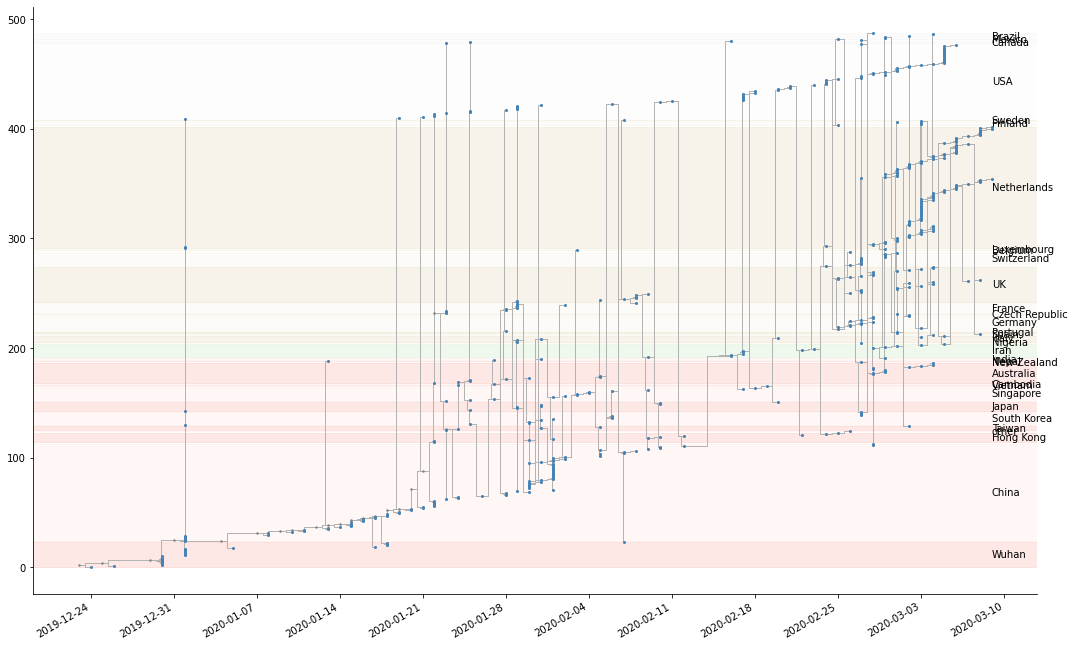

In [427]:
# Utterly hacky code to draw a nice set of edges for the tree

def staircase(n):
    if not n.children:
        return []
    cmin = min(c.t for c in n.children)
    step0 = (n.t, cmin, n.y, n.y)
    upsteps = [step0]
    downsteps = [step0]
    for c in sorted(n.children, key = lambda c: np.abs(c.y-n.y)):
        steps = upsteps if c.y >= n.y else downsteps
        (x0,x1,y) = [(x0,x1,y) for (x0,x1,_,y) in steps if c.t >= x0][-1]
        if c.t < x1:
            steps.append((x0+0.5*(c.t-x0), c.t, y, c.y))
        elif c.y == y:
            steps.append((x1, c.t, y, y))
        else:
            steps.append((x0+0.5*(x1-x0), c.t, y, c.y))
    res = upsteps[1:] + downsteps[1:]
    m1 = min(s[0] for s in upsteps[1:]) if len(upsteps)>1 else n.t
    m2 = min(s[0] for s in downsteps[1:]) if len(downsteps)>1 else n.t
    res = [(n.t, max(m1,m2), n.y, n.y)] + res
    return res



fig,ax = plt.subplots(1,1, figsize=(18,12))

# Draw all the edges of the tree
for n in nodes.values():
    steps = staircase(n)
    for (x0,x1,y0,y1) in steps:
        ax.plot([x0,x0,x1], [y0,y1,y1], lw=1, c='0.7')

# Plot the actual samples (and the inferred samples)
df = pandas.DataFrame([(n.t, n.y, n.is_virtual) for n in nodes.values()], columns=['t','y','v'])        
ax.scatter(df.t[df.v], df.y[df.v], s=2, c='0.5', zorder=10)
ax.scatter(df.t[~df.v], df.y[~df.v], s=4, c='steelblue', zorder=10)

# Shading, to indicate the regions
cm = matplotlib.cm.get_cmap('Pastel1', len(regions))
region_colour = {r: cm(i) for i,(r,_) in enumerate(regions)}
for country,y0,y1,shade in zip(countries, country_base, country_offset-1, itertools.cycle([True,False])):
    ax.axhspan(ymin=y0, ymax=y1, color=region_colour[region[country]], zorder=-10, alpha=.3 if shade else .1)
    ax.text(max(df.t), (y0+y1)/2, country, verticalalignment='center')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator())
fig.autofmt_xdate()

plt.savefig('data/corona-tree.pdf', transparent=True, bbox_inches='tight', pad_inches=0)
plt.savefig('data/corona-tree.png', transparent=False, bbox_inches='tight', pad_inches=0)

plt.show()